In [23]:
library(parallel)

sim.acc <- function(i=1, setups=NULL, err=0.001, boundX=TRUE, method='lp'){
  seed <- setups[i, ]$seed
  maf <- setups[i, ]$maf
  N <- setups[i, ]$N
  Tratio <- setups[i, ]$Tratio
  zscore <- function (x) qnorm((rank(x, na.last = 'keep') - 0.5)/sum(!is.na(x)))

  set.seed(seed)
  nt <- round(N * Tratio)
  x <- rbinom(N, 2, maf)
  Y <- matrix(rnorm(N*nt), N, nt)
  Y <- apply(Y, 2, 'zscore')
  beta <- crossprod(Y, x)
  Y <- t(Y)
  
  cv <- rep(1, N)
  bv <- c((1+err) * beta, (1-err)*beta)
  cd <- c(bv[1:nt] > beta, bv[(nt+1):(2*nt)] > beta)
  cd <- ifelse(cd, '<=', '>=')
  Amat <- rbind(Y, Y)

  ## 0 <= x <= 2
  if(boundX & method=='lp'){
    bv <- c(bv, rep(0, N), rep(2, N))
    cd <- c(cd, rep('>=', N), rep('<=', N))
    Amat <- rbind(Amat, diag(rep(1, N)), diag(rep(1, N)))
  }

  if(method=='lp'){
    res <- linprog::solveLP(cvec=cv, bvec=bv, Amat=Amat, maximum=FALSE, const.dir=cd, lpSolve=TRUE, solve.dual=FALSE)
  }else if(method=='mip'){
    res <- suppressWarnings(Rglpk::Rglpk_solve_LP(obj=cv, mat=Amat, dir=cd, rhs=bv,
                                 bounds=list(lower=rep(0, N), upper=rep(2, N)),
                                 types='I', max=FALSE, control=list(verbose=FALSE, tm_limit=10000)))
  }

  xhat <- round(pmax(pmin(as.vector(res$solution), 2), 0), 0)
  ct <- sum(xhat == x, na.rm=TRUE)
  cf <- sum(xhat != x, na.rm=TRUE)
  acc <- ct / (ct+cf)
  return(c(seed, maf, sum(x)/N/2, N, Tratio, acc, res$status))
#   return(data.frame(seed=seed, maf=maf, af=sum(x)/N/2, N=N, Tratio=Tratio, acc=acc, status=res$status))
}

chunk.acc <- function(s, size=50, setups=NULL){
  e <- s + size - 1
  e <- min(e, nrow(setups))
  size <- e - s + 1
  res <- matrix(NA, nrow=size, ncol=7)
  for(i in s:e){
    res[i-s+1, ] <- sim.acc(i, setups)
  }
  res <- as.data.frame(res)
  colnames(res) <- c('seed', 'maf', 'af', 'N', 'Tratio', 'acc', 'status')
  return(res)
}

size <- 20
ncpus <- 4
nreps <- 30
setups <- as.data.frame(expand.grid(
  maf=c(0.05, seq(0.1, 0.5, by=0.1)),
  Tratio=seq(0.1, 1, by=0.1),
  N=c(300, 500, 1000),
  irep=1:nreps))
set.seed(1432817)
setups$seed <- sample(999999999, size=nrow(setups))

ss <- seq(1, nrow(setups), by=size)
clust <- makeCluster(ncpus, outfile='')
clusterExport(clust, varlist=c('sim.acc'))
df <- do.call('rbind', parLapply(clust, ss, chunk.acc, size=size, setups=setups))
stopCluster(clust)

write.table(df, file='sim.tsv', sep='\t', quote=F, row.names=F, col.names=T)

In [1]:
df <- fread('sim-x02.tsv')

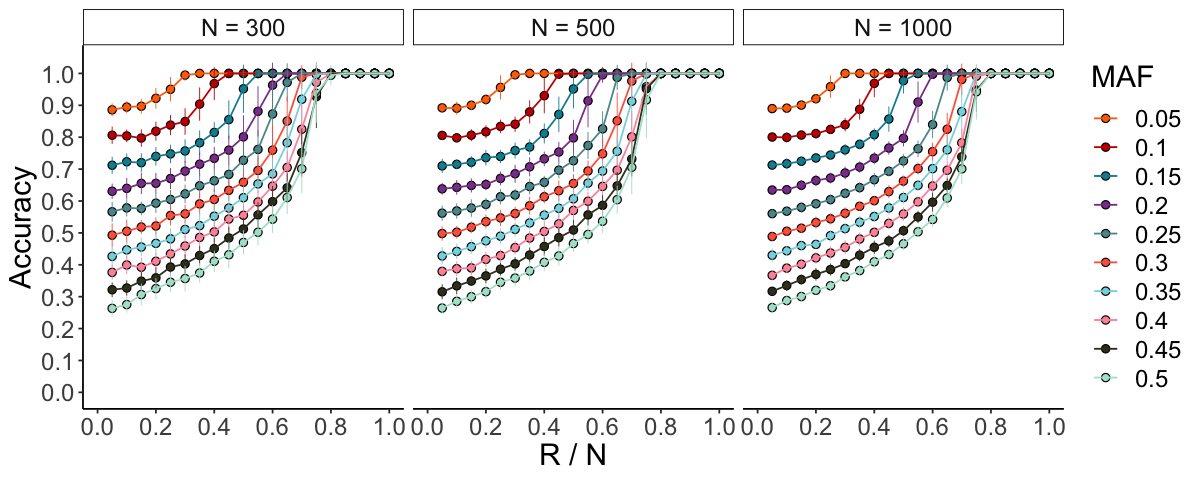

In [4]:
mycols <- c('#FF6F00FF', '#C71000FF', '#008EA0FF', '#8A4198FF', '#5A9599FF', '#FF6348FF',
            '#84D7E1FF', '#FF95A8FF', '#3D3B25FF', '#ADE2D0FF', '#1A5354FF', '#3F4041FF')

df %>%
  filter(!is.na(acc)) %>%
  arrange(N) %>%
  mutate(N=paste0('N = ', N)) %>%
  mutate(N=factor(N, levels=unique(.$N))) %>%
  group_by(maf, N, Tratio) %>%
  mutate(acc.sd=sd(acc), acc.mean=mean(acc)) %>%
  ungroup() %>%
  distinct(maf, N, Tratio, acc.sd, acc.mean) %>%

  ggplot() + jptheme(10, 4, 18) +
  geom_point(aes(x=Tratio, y=acc.mean, fill=factor(maf)), col='black', shape=21, size=2) +
  geom_line(aes(x=Tratio, y=acc.mean, color=factor(maf)), lwd=0.5, lty=1) +
  geom_segment(aes(x=Tratio, xend=Tratio, y=acc.mean-acc.sd, yend=acc.mean+acc.sd, color=factor(maf)), lwd=0.25) +
  facet_wrap(.~N) +
  scale_fill_manual(values=mycols) +
  scale_color_manual(values=mycols) +
  labs(x='R / N', y='Accuracy', fill='MAF', color='MAF') +
  scale_y_continuous(breaks=seq(0, 1, by=0.1), limits=c(0, NA)) +
  scale_x_continuous(breaks=seq(0, 1, by=0.2), limits=c(0, NA)) +
  theme(panel.border = element_blank(), axis.line=element_line(color='black'),
        strip.background=element_rect(fill=NA, color='black'))

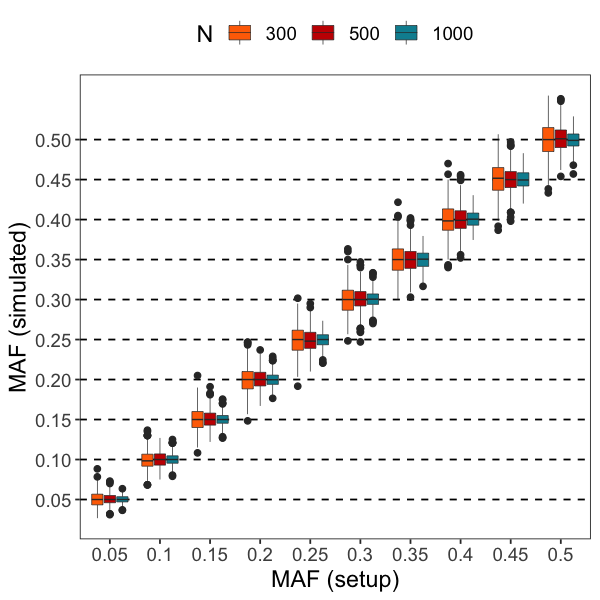

In [3]:
df %>%
  filter(!is.na(acc)) %>%
  ggplot() + jptheme(5, 5, 14) +
  geom_hline(aes(yintercept=maf), lty=2, color='black') +
  geom_boxplot(aes(x=factor(maf), y=af, fill=factor(N)), lwd=0.2) +
  scale_y_continuous(breaks=seq(0, 0.5, by=0.05)) +
  scale_fill_manual(values=mycols) +
  labs(x='MAF (setup)', y='MAF (simulated)', fill='N') +
  theme(legend.position='top')